In [43]:
import pylab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
flow = pd.read_csv("flow.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
occupancy = pd.read_csv("occupancy.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
speed = pd.read_csv("speed.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)
timestamp = pd.read_csv("timestamp.tsv", na_values=['-'], delimiter="\t", error_bad_lines=False)

In [46]:
df = pd.concat([flow,occupancy,speed,timestamp], axis=1)


In [47]:
df.columns = ['flow1','flow2', 'flow3','occupancy1','occupancy2','occupancy3','speed1','speed2','speed3','timestamp']
df.head()

flow1  flow2  flow3  occupancy1  occupancy2  occupancy3  speed1  speed2  \
0      9      4    255         4.0         2.0         4.0    67.0    60.0   
1     11     10    255         4.0         5.0         4.0    66.0    64.0   
2     -8      3    255         3.0         1.0         4.0    71.0    63.0   
3      5      9    255         2.0         3.0         4.0    65.0    70.0   
4      7     10    255         2.0         4.0         4.0    66.0    64.0   

   speed3            timestamp  
0     0.0  2006-09-01T00:01:07  
1     0.0  2006-09-01T00:02:07  
2     0.0  2006-09-01T00:03:07  
3     0.0  2006-09-01T00:04:07  
4     0.0  2006-09-01T00:05:08

In [48]:
df1 =  pd.DataFrame({"flow" : df.flow1, "occupancy" : df.occupancy1,"speed" : df.speed1,"timestamp" : df.timestamp,"detector" : "x"})
df2 = pd.DataFrame({"flow" : df.flow2, "occupancy" : df.occupancy2,"speed" : df.speed2,"timestamp" : df.timestamp,"detector" : "y"})
df3 = pd.DataFrame({"flow" : df.flow3, "occupancy" : df.occupancy3,"speed" : df.speed3,"timestamp" : df.timestamp,"detector" : "z"})

In [49]:
frames = [df1, df2, df3]
result = pd.concat(frames)

In [50]:
result = result.sort_values("timestamp")

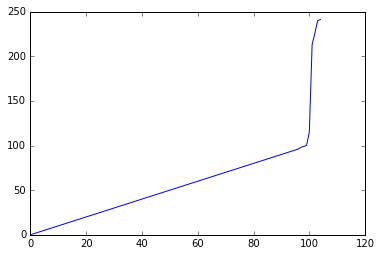

In [51]:
# Finding outlier values for Occoupancy
val = np.sort(result["occupancy"].unique())
plt.plot(val)

# so keeping occupancy threshold as 120 since all values above them show a steep change indicating possible outliers.
# jam_occupancy_threshold = 120

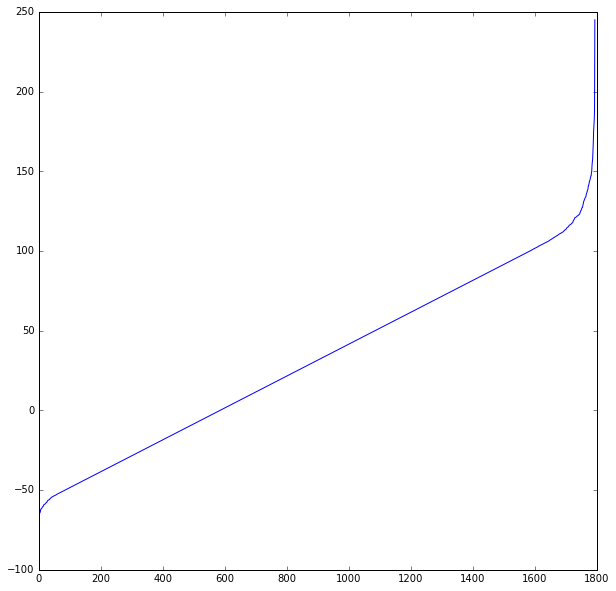

In [53]:
# Outlier speed visualization
plt.figure(figsize=(10,10))
# plt.xlim(550, 650)
plt.plot(np.sort(result["speed"].unique()))

In [10]:
removeResult1 = result[(result['speed'] < 0) | (result['flow'] < 0)]
removeResult2 = result[(result['flow'] == 0) & (result['speed'] > 0)]
jam_occupancy_threshold = 120
removeResult3 = result[((result['speed'] == 0) & 
                            (result['flow'] == 0) & 
                            (result['occupancy'] != 0) & 
                            (result['occupancy'] < jam_occupancy_threshold))]
# skewed data
removeResult4 = result[(result['speed'] == 0) & (result['flow'] == 0) & (result["occupancy"] == 0)]
removeResult5 = result[(result['speed'] == 0) & (result['flow'] != 0) & (result["occupancy"] == 0)]

In [11]:
res = result.set_index(["timestamp","detector"]).sort_index()

In [12]:
result = pd.concat([result,removeResult1,removeResult1]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult2,removeResult2]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult3,removeResult3]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult4,removeResult4]).drop_duplicates(keep=False)
result = pd.concat([result,removeResult5,removeResult5]).drop_duplicates(keep=False)

In [13]:
result = result.sort_values(["flow"])

In [14]:
def sampleData(data, threshold, columnName):
    flowBins = np.zeros(shape=(20,), dtype = object)
    data = data.sort_values(columnName)
    difference = threshold
    high  = difference
    low = 0;
    for i in range(0, 20, 1):
        b = data[data[columnName] < high]
        b = b[b[columnName] >= low]
        flowBins[i] = b
        low = high
        high = high + difference
    return flowBins

In [15]:
flowBins = np.zeros(shape=(20,), dtype = object)
flowBins = sampleData(result, 15 ,"flow")    

In [ ]:
np.sort(flowBins[10].occupancy.unique())

In [16]:
import numpy as np
flow_occupancy_bin = np.ndarray(shape=(20,20), dtype = object)
for i in range(0,20,1):
    data = pd.DataFrame(flowBins[i])
    flow_occupancy_bin[i] = sampleData(data, 6 ,"occupancy") 

In [ ]:
flow_occupancy_bin[10][0]

In [ ]:
flow_occupancy_bin.shape

In [17]:
import numpy as np
flow_occupancy_speed_bin = np.ndarray(shape=(20,20,20), dtype = object)
y = 1;

for i in range(0,20,1):
    for j in range(0,20,1):
        data = flow_occupancy_bin[i][j];
        flow_occupancy_speed_bin[i][j] = sampleData(data, 13 ,"speed") 

In [ ]:
flow_occupancy_speed_bin[0][1][5]

In [18]:
final_result = pd.DataFrame(columns = ["detector","flow","occupancy","speed","timestamp", "probability"])
total_points = len(result)
#final_result = ["0" , "0", "0", "0"]
for i in range(0,20,1):
    for j in range(0,20,1):
        for k in range(0,20,1):
            prob_data = flow_occupancy_speed_bin[i][j][k]
            points_inside_box = prob_data.shape[0]
            f = prob_data.flow.max() - prob_data.flow.min()
            o = prob_data.occupancy.max() - prob_data.occupancy.min()
            s = prob_data.speed.max() - prob_data.speed.min()
            #volume = f*o*s
            volume = 1170
            if(volume == 0): volume =1
            probability = points_inside_box/float(total_points * volume)
#             print(prob_data)
            prob_data["probability"] = probability
            prob_data.to_csv("output/out" + str(i) + '-' + str(j) + '-' + str(k) + ".csv",sep="\t")
#             print(prob_data.head(1))
#           final_result.add([prob_data['flow'], prob_data['speed'], prob_data['occupancy'], prob_data['probability']])
            #final_result_align, prob_data_align = final_result.align(prob_data,axis=1)
            #final_result = pd.concat([final_result_align, prob_data_align])
            #final_result = np.append(final_result, [prob_data['flow'], prob_data['speed'], prob_data['occupancy'], prob_data['probability']])

In [19]:
! cat output/*.csv > merged.csv

In [20]:
!rm -rf output/

In [ ]:
probability

In [ ]:
# .00000520634
print (f,o,s)

In [21]:
merged = pd.read_csv("merged.csv", na_values=['-'], delimiter="\t", error_bad_lines=False)

/Users/abhisek/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (2,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
removeHeader = merged[merged["probability"] == "probability"]

In [23]:
merged = pd.concat([merged,removeHeader,removeHeader]).drop_duplicates(keep=False)

In [24]:
merged.tail()

Unnamed: 0 detector flow occupancy speed            timestamp  \
4159293    655560.0        x  145       4.0  20.0  2008-04-10T16:42:17   
4159314    132745.0        x  142       9.0  19.0  2007-01-25T16:30:32   
4159535    456477.0        x  135      14.0  16.0  2007-10-31T16:59:46   
4159536   1243268.0        x  140      14.0  18.0  2009-07-01T15:49:49   
4159577   1726037.0        x  140      24.0  15.0  2010-07-08T18:30:49   

               probability  
4159293  6.17602896765e-10  
4159314  2.05867632255e-10  
4159535   4.1173526451e-10  
4159536   4.1173526451e-10  
4159577  2.05867632255e-10

In [25]:
merged["probability"] = merged["probability"].apply(pd.to_numeric)
merged = merged.sort_values(["probability"])
final_columns = ['flow', 'speed', 'occupancy', 'probability']
merged = merged[final_columns]

In [26]:
merged.head()

flow  speed occupancy   probability
4159577  140   15.0      24.0  2.058676e-10
4150777   48  115.0       2.0  2.058676e-10
4150772   49   82.0       5.0  2.058676e-10
4150509   46  149.0       1.0  2.058676e-10
4158433  105   22.9       0.0  2.058676e-10

In [38]:
# merged
final_result = pd.DataFrame(columns = ["flow","speed","occupancy", "probability"])
for i in range(0,len(merged),100):
    final_result = final_result.append(merged.iloc[[i]])

In [39]:
final_result.to_csv("1160.txt",sep="\t")

In [33]:
final_result.head()

Empty DataFrame
Columns: [flow, speed, occupancy, probability]
Index: []

In [35]:
# len(merged)